<div class="alert alert-block alert-info">
This tutorial includes 6 lab questions. The questions have headers like <font color='red'><b>Lab question 1</b></font> in red font. Answer all 6 questions. There are no challenge questions in this notebook. Submit your answers via WebCT and remember to paste in the question text (that really helps me grade faster!).  
</div>

# Neural networks, Part 1: Linear logic functions as networks

In this tutorial, we are going to start building networks that implement logical functions. This is going to pave the way for more interesting and advanced topics. We are going to find that it becomes hard to build networks by hand for anything but the simplest functions. However, we can use methods for training networks that are capable of *discovering* (through trial and error -- lots of trials and lots of errors!) effective weights. 

Let's start by building some simple networks. Here's one to start things off. 

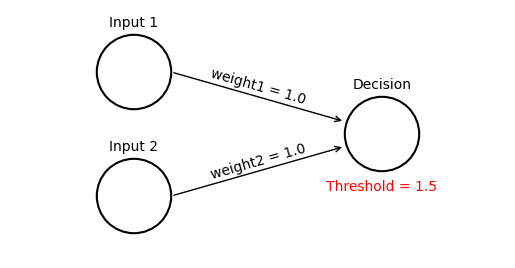

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def draw_neuron_with_label(ax, pos, neuron_text, label):
    # Drawing a neuron with label and black outline
    circle = patches.Circle(pos, radius=0.15, fill=False, edgecolor='black', linewidth=1.5)
    ax.add_patch(circle)
    ax.text(pos[0], pos[1] + 0.18, label, horizontalalignment='center')
    ax.text(*pos, neuron_text, horizontalalignment='center', verticalalignment='center', color='black')

def draw_connection_with_weight(ax, start, end, weight):
    # Drawing a directed arrow with weight label
    ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='->'))
    mid = ((start[0] + end[0]) / 2, (start[1] + end[1]) / 2)
    
    # Calculate angle for text rotation
    dx, dy = end[0] - start[0], end[1] - start[1]
    angle = np.degrees(np.arctan2(dy, dx))
    
    ax.text(mid[0], mid[1] + -0.03, weight, horizontalalignment='center', rotation=angle)

# Creating the figure
fig, ax = plt.subplots()
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)
ax.set_aspect('equal')  # Ensures the circles are perfectly round

# Draw Neurons with Labels
draw_neuron_with_label(ax, (1.5, 0.5), '', 'Decision')
draw_neuron_with_label(ax, (0.5, 0.75), '', 'Input 1')
draw_neuron_with_label(ax, (0.5, 0.25), '', 'Input 2')

# Add Threshold Label in Red Below the Decision Node
ax.text(1.5, 0.27, 'Threshold = 1.5', horizontalalignment='center', color='red')

# Draw Connections with Weights
draw_connection_with_weight(ax, (0.65, 0.75), (1.35, 0.55), 'weight1 = 1.0')
draw_connection_with_weight(ax, (0.65, 0.25), (1.35, 0.45), 'weight2 = 1.0')

plt.axis('off')
plt.show()


## <font color='red'>Lab question 1: mystery network</font>

Can you figure out what function the network above implements? You can do some mental simulations to work it out. Imagine we give the network the inputs 1 and 0. What is the resulting activation of the Decision node? Since both weights are set to 1.0, we simply do $(1 \cdot 1) + (0 \cdot 1) =\ \rule{.5cm}{0.15mm}$. Now we ask: is this result larger than 1.5? If not, the Decision node value will be set to zero. It will be set to 1 if the input is greater than the threshold. Given this, what function does the network implement? 

*Try to answer this without looking ahead. If you get stuck, read on and come back to this later.*

---

## An aside

We will come back to networks shortly, but before we do, let's get set up to be able to do more complex network diagrams. 

---


## Visualize, visualize, visualize

My mantra with any kind of data or mechanism is *visualize, **visualize**, visualize*. If you do not visualize data, you can be badly led astray. You may make assumptions and not realize they are not valid. You might miss some obvious pattern or problem in your data that visualization can reveal.


It can also be super helpful to image / visualize networks and details like connection weights. When we do this, it can help us understand the functional implications of the network architecture.

For a small network, we can create a diagram of the network that also displays weights as text annotations. For very large networks, we might need to consider things like 'heatmap' plots of weight matrices. But we will be working with fairly small networks for now, so let's start with the diagram approach. 

I created some functions in python to give us simple plots of networks. The functions are in `network_plotter.py`. You define a data structure that defines your network. It's a nested list where each 'column' is a list of nodes in a layer (e.g., 'Input 1', 'Input 2'). For layers (columns) with more than 1 node, it spreads them across the vertical extent of the layer with the most nodes. If there is just 1 node, it centers it vertically. Then it can draw connections between nodes. If you define weights for the nodes, it can print the weights at random positions along the arrow connecting nodes (using random positions usually succeeds in avoiding weights being printed on top of each other). 

You also have options to make connections 'bow'. This is particularly useful if you have feedback connections where you also have feedforward connections; you can make the feedback connections bow so they are not on top of the feedforward connections. By default, if you do not specify an `edge_color` for feedback connections, they will be red. Here's an elaborate example, where we generate random connection weights in a network with 2 inputs, 4 hidden nodes, and 1 output nodes. Feedforward layers are fully connected (every node in a lower layer has a connection to every node in the next layer). In addition, there are feedback connections from the output node to the first and last hidden nodes, and from the first hidden node to the first input node. 

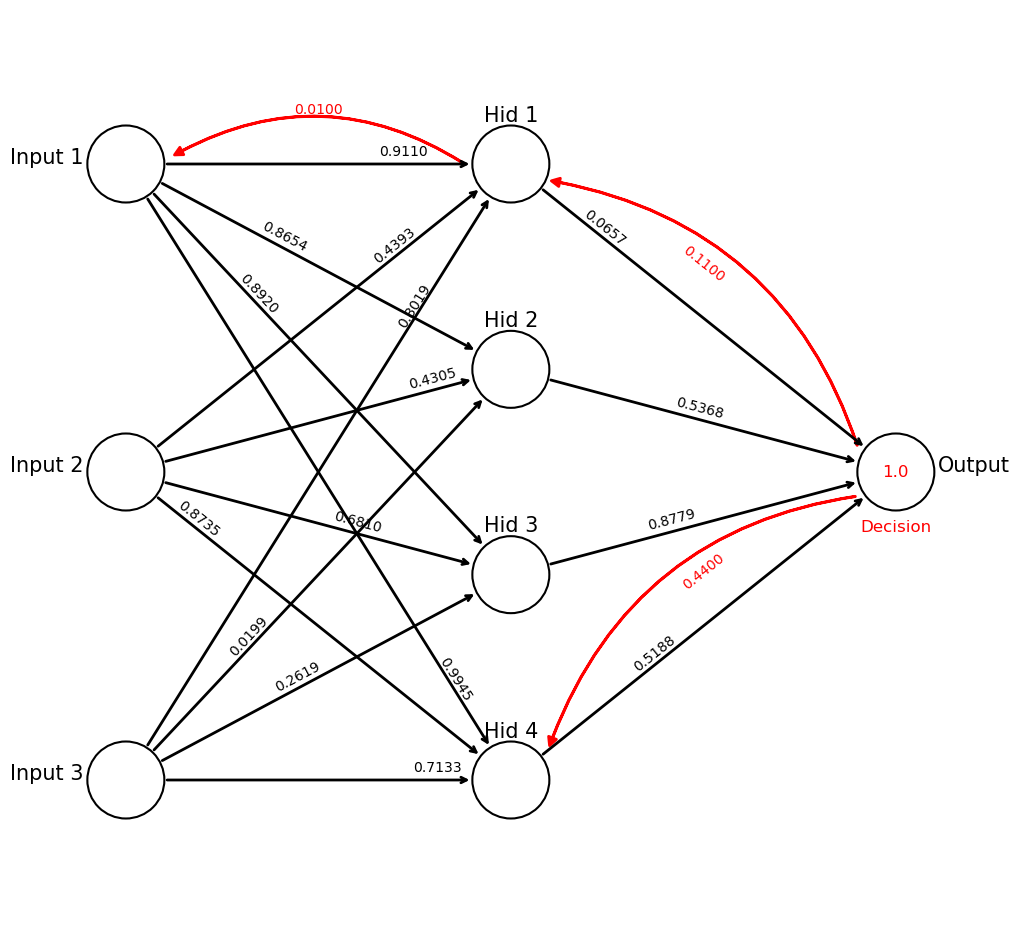

In [3]:
import network_plotter as netplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plot_width=10.0
plot_height = plot_width
fig_width=plot_width*1.2
fig_height = fig_width
figsize = (fig_width, fig_height) 

# Node / layers definition
layers = [
    ['Input 1', 'Input 2', 'Input 3'],
    ['Hid 1', 'Hid 2', 'Hid 3', 'Hid 4'],
    ['Output']
]

# Generate random weights based on the size of layers
#np.random.seed(0)  # For reproducibility
input_to_hidden_weights = np.random.rand(len(layers[0]), len(layers[1]))  # Weights from inputs to hidden nodes
hidden_to_output_weights = np.random.rand(len(layers[1]))  # Weights from hidden nodes to the output node


# Creating the figure with specified size
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlim(0, fig_width) 
ax.set_ylim(0, fig_height) 
ax.set_aspect('equal', adjustable='box')  # Adjust aspect ratio to fit the plot_width

# Calculate node positions with the specified plot width
node_positions = netplot.calculate_node_positions(layers, plot_width, fig_width, fig_height) # , offset=0.3)

# Draw Neurons with Labels
num_layers = len(layers)
subtext=''
nodetext=''
for i, column in enumerate(layers):
    for node in column:
        pos = node_positions[node]
        if i == num_layers - 1:
            subtext='Decision'
            nodetext = '1.0'
        netplot.draw_neuron_with_label(ax, pos, node, i, num_layers, plot_width=plot_width, subtext=subtext, nodetext=nodetext)

# Draw Connections with Weights
for i, input_node in enumerate(layers[0]):
    for j, hidden_node in enumerate(layers[1]):
        weight = input_to_hidden_weights[i, j]
        netplot.draw_connection_with_weight(ax, node_positions, input_node, hidden_node, weight, show_weight=True, plot_width=plot_width)

# Draw connections from hidden nodes to the decision node
for j, hidden_node in enumerate(layers[1]):
    bow=False
    weight = hidden_to_output_weights[j]
    # uncomment next line to make one connection bowed
    #bow = hidden_node == 'Hid 4'  # Only bow the connection for Hidden4
    netplot.draw_connection_with_weight(ax, node_positions, hidden_node, 'Output', weight, show_weight=True, bow=bow, plot_width=plot_width)
  
netplot.draw_connection_with_weight(ax, node_positions, 'Output', 'Hid 4', 0.44, show_weight=True, bow=True, plot_width=plot_width) # , edge_color='pink')
netplot.draw_connection_with_weight(ax, node_positions, 'Output', 'Hid 1', 0.11, show_weight=True, bow=True, plot_width=plot_width) # , edge_color='pink')
netplot.draw_connection_with_weight(ax, node_positions, 'Hid 1', 'Input 1', 0.01, show_weight=True, bow=True, plot_width=plot_width) # , edge_color='pink')


plt.axis('off')
plt.show()
#print(input_to_hidden_weights)
#print(hidden_to_output_weights)


There are some other 'neatening' touches, like putting labels for the first column to the left of nodes, and labels for the last column to the right, with labels for intermediate nodes above the nodes. You can also toggle labels on and off for both nodes and links / edges. If you print the weights next to the links, the positions are set to random positions along the edge to try to avoid weights being printed on top of each other. If you are unhappy with the weight text placement, you can regenerate it just by clicking in the code block and hitting the 'play' / 'execute' icon. (Note that the labels for feedback connections are not randomly nudged at all, but could be.) You can also specify a 'subtext' for any node when it is drawn; in the example below, 'Decision' is added as subtext for any node in the last layer. You can also specify 'nodetext' which will be printed in the center of a node. This could be activation values, or the threshold for the node to fire, for example. In the code below, a value of 1.0 is printed inside any output node. 

Some minor blemishes: to keep feedback nodes from obscuring feedforward nodes, the start and end positions of bowed connections are shifted slightly. This usually works okay, but it's not perfect. Weight text is usually above lines but occasionally touch lines. To change the plot size, just change plot_width. There may be some plot sizes where things won't work perfectly. Annoyingly, I can only get the nodes to plot as circles when the aspect ratio for the whole plot is 1:1 (node aspect ratio is same as plot aspect ratio, so if the plot is twice as wide as it is tall, the nodes will also be twice as wide as they are tall). 

However, because the 'nudges' are random, just re-running the codeblock above will give you a new graph, and you can just keep running it until it is good enough... 

---

## Back to logical function networks

Now let's work towards making networks that can implement (nonexclusive) OR, AND, NAND, and XOR (exclusive or). Let's start with a network that can implement OR. 

---

## OR

The OR function is one of our basic operations in boolean logic. It's useful for logic, but also applications like building digital circuits. It takes two boolean inputs and returns a true value if at least one of the inputs is true. The function is often symbolized as $\vee$  or (usually in programming languages) as $\parallel$ (and sometimes `|`).

## Truth table for nonexclusive OR

In a 'truth table', we simply list out the possible input states and resulting output states. Here is the truth table for the OR function:

| Input A | Input B | Output (A OR B) |
|:-------:|:-------:|:---------------:|
| False   | False   | False           |
| False   | True    | True            |
| True    | False   | True            |
| True    | True    | True            |

The output is only false when both inputs are false.

We can rewrite this using numbers, where 0 = False and 1 = True.

| Input A | Input B | Output (A OR B) |
|:-------:|:-------:|:---------------:|
| 0       | 0       | 0               |
| 0       | 1       | 1               |
| 1       | 0       | 1               |
| 1       | 1       | 1               |

Note that we can extend this to arbitrarily many inputs, though we will stick with 2 inputs for now. But just to illustrate, here's a truth table nonexclusive OR with 3 inputs. Again, there is only 1 case where the output will be False. Make sure you understand why. If it's not clear, ask me! 

| Input A | Input B | Input C | Output (A OR B OR C) |
|:-------:|:-------:|:-------:|:--------------------:|
| False   | False   | False   | False                |
| False   | False   | True    | True                 |
| False   | True    | False   | True                 |
| False   | True    | True    | True                 |
| True    | False   | False   | True                 |
| True    | False   | True    | True                 |
| True    | True    | False   | True                 |
| True    | True    | True    | True                 |



## A network for nonexclusive OR

Now let's make a diagram, using the `network_plotter.py` library file (which we load via `import network_plotter as netplot`). The network will be wider than I'd like, but currently, this is best we can do with the library and a small network. Run the next code block to see the network. Note that if we change the threshold on the output to be 1 if the input is greater than 0. 

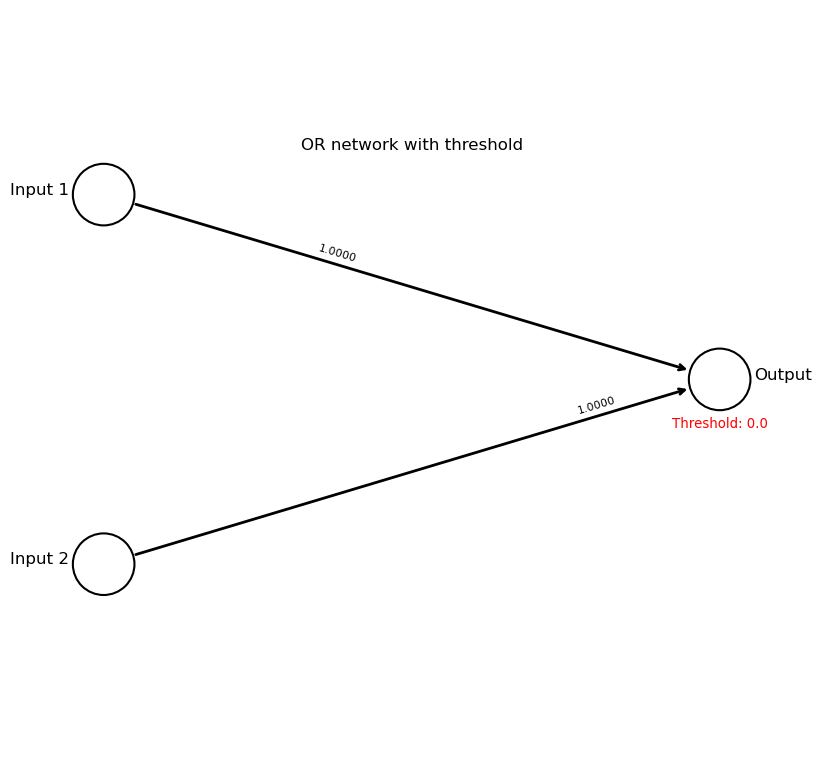

In [4]:
import network_plotter as netplot
import numpy as np
import matplotlib.pyplot as plt

# Setup for plot
plot_width = 8.0
plot_height = plot_width
fig_width = plot_width * 1.2
fig_height = fig_width
figsize = (fig_width, fig_height)

# Define a simpler network for the OR function
layers_or = [
    ['Input 1', 'Input 2'],
    ['Output']
]

# Set weights for the OR function (both to 1.0)
input_to_output_weights_or = np.array([1.0, 1.0])  # Weights from inputs to the output node

# Creating the figure for the OR network
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlim(0, fig_width)
ax.set_ylim(0, fig_height)
ax.set_aspect('equal', adjustable='box')

# Calculate node positions for the OR network
node_positions_or = netplot.calculate_node_positions(layers_or, plot_width, fig_width, fig_height)

# Draw Neurons with Labels for the OR network
num_layers_or = len(layers_or)
subtext_or = ''
nodetext_or = ''
for i, column in enumerate(layers_or):
    for node in column:
        pos = node_positions_or[node]
        if i == num_layers_or - 1:
            subtext_or = 'Threshold: 0.0'
            nodetext_or = ''
        netplot.draw_neuron_with_label(ax, pos, node, i, num_layers_or, plot_width=plot_width, subtext=subtext_or, nodetext=nodetext_or)

# Draw Connections with Weights for the OR network
for i, input_node in enumerate(layers_or[0]):
    weight = input_to_output_weights_or[i]
    netplot.draw_connection_with_weight(ax, node_positions_or, input_node, 'Output', weight, show_weight=True, plot_width=plot_width)

plt.title('OR network with threshold', x=0.5, y=0.8)
plt.axis('off')
plt.show()


---

## <font color='red'>Lab question 2</font>

(a) Explain how this network implements OR. Remember, when we set a threshold, it means that if the input exceeds that value, the node will have an activation of 1.0; otherwise, it will have an activation of 0.0. 

(b) Generate a different set of weights that will give the same result; you can change the threshold if you like, but you don't need to (that is, there are different weights that will work with the 0.0 threshold). 

---

## Checking the network outputs

We can write a simple function to test the outputs this network will give to all possible 1,0 combinations. 

In [5]:
def or_network(input1, input2, weight1=1.0, weight2=1.0, threshold=0.0):
    #weight1, weight2 = 1.0, 1.0  # Weights for the input nodes
    #threshold = 0.0  # Threshold for activation

    # Compute the weighted sum
    weighted_sum = input1 * weight1 + input2 * weight2

    # Check if the weighted sum meets or exceeds the threshold
    myoutput = 1 if weighted_sum > threshold else 0
    return myoutput

# Test the network on all possible input combinations
input_combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
for inputs in input_combinations:
    output = or_network(*inputs)
    print(f"Input: {inputs}, Output: {output}")


Input: (0, 0), Output: 0
Input: (0, 1), Output: 1
Input: (1, 0), Output: 1
Input: (1, 1), Output: 1


--- 

## An AND network

Now let's tackle AND. Here's the truth table:

| Input A | Input B | Output (A AND B) |
|:-------:|:-------:|:----------------:|
| False   | False   | False            |
| False   | True    | False            |
| True    | False   | False            |
| True    | True    | True             |

The output is true only when both inputs are true.

Here it is rewritten with 1s and 0s. 

| Input A | Input B | Output (A AND B) |
|:-------:|:-------:|:----------------:|
| 0       | 0       | 0                |
| 0       | 1       | 0                |
| 1       | 0       | 0                |
| 1       | 1       | 1                |

Now let's try to make a network that can implement the AND function. 


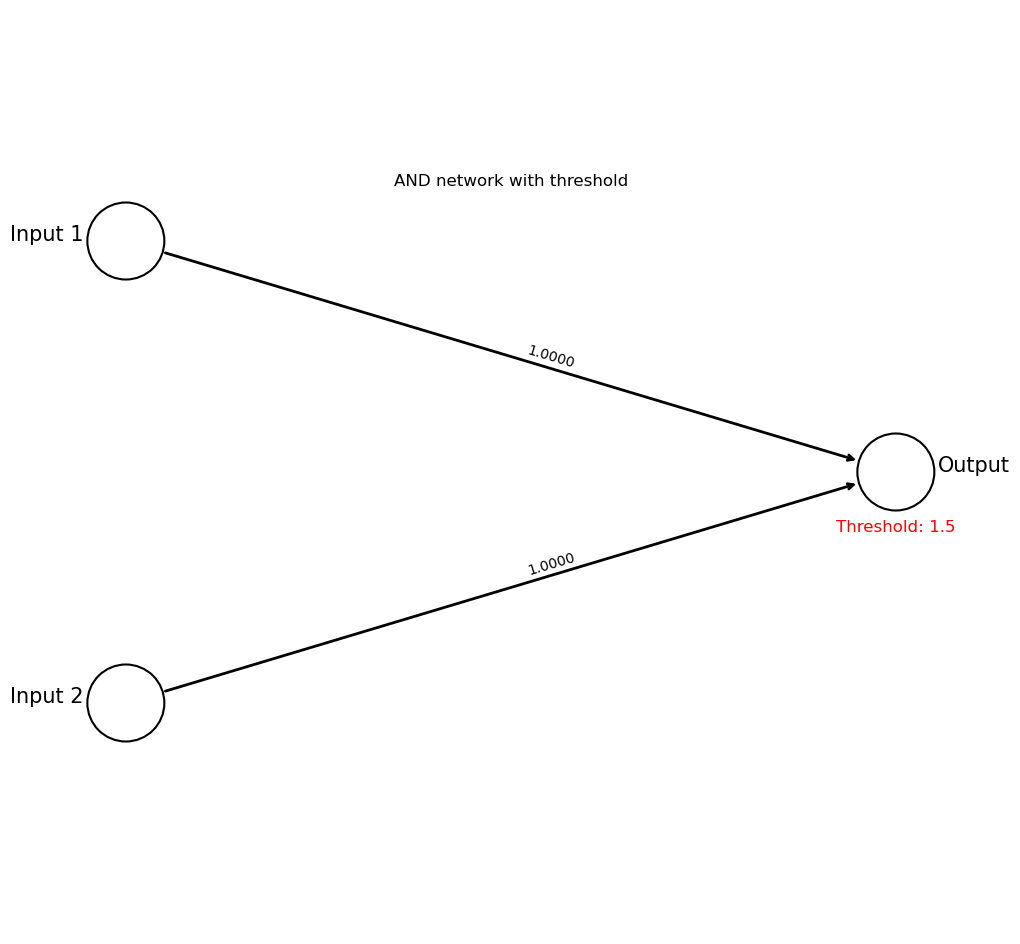

In [6]:
import network_plotter as netplot
import numpy as np
import matplotlib.pyplot as plt

# Setup for the AND network plot
plot_width = 10.0
plot_height = plot_width
fig_width = plot_width * 1.2
fig_height = fig_width
figsize = (fig_width, fig_height)

# Define the network for the AND function
layers_and = [
    ['Input 1', 'Input 2'],
    ['Output']
]

# Set weights for the AND function
# Both inputs need to be 1 to exceed the threshold of 1.5
input_to_output_weights_and = np.array([1.0, 1.0])

# Creating the figure for the AND network
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlim(0, fig_width)
ax.set_ylim(0, fig_height)
ax.set_aspect('equal', adjustable='box')

# Calculate node positions for the AND network
node_positions_and = netplot.calculate_node_positions(layers_and, plot_width, fig_width, fig_height)

# Draw Neurons with Labels for the AND network
num_layers_and = len(layers_and)
subtext_and = ''
nodetext_and = ''
for i, column in enumerate(layers_and):
    for node in column:
        pos = node_positions_and[node]
        if i == num_layers_and - 1:
            subtext_and = 'Threshold: 1.5'
        netplot.draw_neuron_with_label(ax, pos, node, i, num_layers_and, plot_width=plot_width, subtext=subtext_and, nodetext=nodetext_and)

# Draw Connections with Weights for the AND network
for i, input_node in enumerate(layers_and[0]):
    weight = input_to_output_weights_and[i]
    netplot.draw_connection_with_weight(ax, node_positions_and, input_node, 'Output', weight, show_weight=True, plot_width=plot_width)

plt.title('AND network with threshold', x=0.5, y=0.8)
plt.axis('off')
plt.show()


---

## <font color='red'>Lab question 3</font>

(a) Explain how this network implements AND. Remember, when we set a threshold, it means that if the input reaches that value, the node will have an activation of 1.0; otherwise, it will have an activation of 0.0. 

(b) Generate a different set of weights that will give the same result; you may have to change the threshold. 

---

## Checking the network outputs

As we did for OR, we can write a simple function to test the outputs this network will give to all possible 1,0 combinations. 

In [7]:
def and_network(input1, input2):
    weight1, weight2 = 1.0, 1.0  # Weights for the input nodes
    threshold = 1.5  # Threshold for activation

    # Compute the weighted sum
    weighted_sum = input1 * weight1 + input2 * weight2

    # Check if the weighted sum meets or exceeds the threshold
    output = 1 if weighted_sum > threshold else 0
    return output

# Test the network on all possible input combinations
input_combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
for inputs in input_combinations:
    output = and_network(*inputs)
    print(f"Input: {inputs}, Output: {output}")


Input: (0, 0), Output: 0
Input: (0, 1), Output: 0
Input: (1, 0), Output: 0
Input: (1, 1), Output: 1


<div class="alert alert-block alert-info">
<b>Note:</b> <i>When we set the threshold to 1.5 for AND, this is larger than it has to be, isn't it? We could have set it to 1.000001, which is a sum that could only be exceeded if both inputs were 1. We generally use a larger threshold that makes things quite clear. In practice, if you had any possibility of noisy inputs (e.g., values ranging from 0.9 to 1.1 for 'True' and from 0 to 0.1 for 'False'), you would want to set the threshold small enough to capture cases where both values are True but low (0.9, 0.9) but also high enough to exclude cases where one input has a high value for False (0.1) and the other has a high value for True (1.1). </i></div>

--- 

## A NAND network

Now let's make a network for NAND -- 'not AND'. What should the truth table look like? It should have *opposite* outputs when compared to the AND truth table. Remember, here's what the **AND truth table** looks like:


| Input A | Input B | Output (A AND B)               |
|:-------:|:-------:|:------------------------------:|
| False   | False   | <font color='red'>False</font> |
| False   | True    | <font color='red'>False</font> |
| True    | False   | <font color='red'>False</font> |
| True    | True    | <font color='darkgreen'>True</font> |


## NAND truth tables

| Input A | Input B | Output (A NAND B) |
|:-------:|:-------:|:----------------:|
| False   | False   |  <font color='darkgreen'>True</font> |
| False   | True    |  <font color='darkgreen'>True</font>        |
| True    | False   |  <font color='darkgreen'>True</font>        |
| True    | True    |  <font color='red'>False</font>      |

The output is true only when both inputs are true.

Here it is rewritten with 1s and 0s. 

| Input A | Input B | Output (A NAND B) |
|:-------:|:-------:|:----------------:|
| 0       | 0       | **1**            |
| 0       | 1       | **1**            |
| 1       | 0       | **1**            |
| 1       | 1       | **0**            |

Do you see why? We are defining a function that gives a 1 when AND is **not** true, and 0 otherwise. 

Let's make a network for the NAND function. 


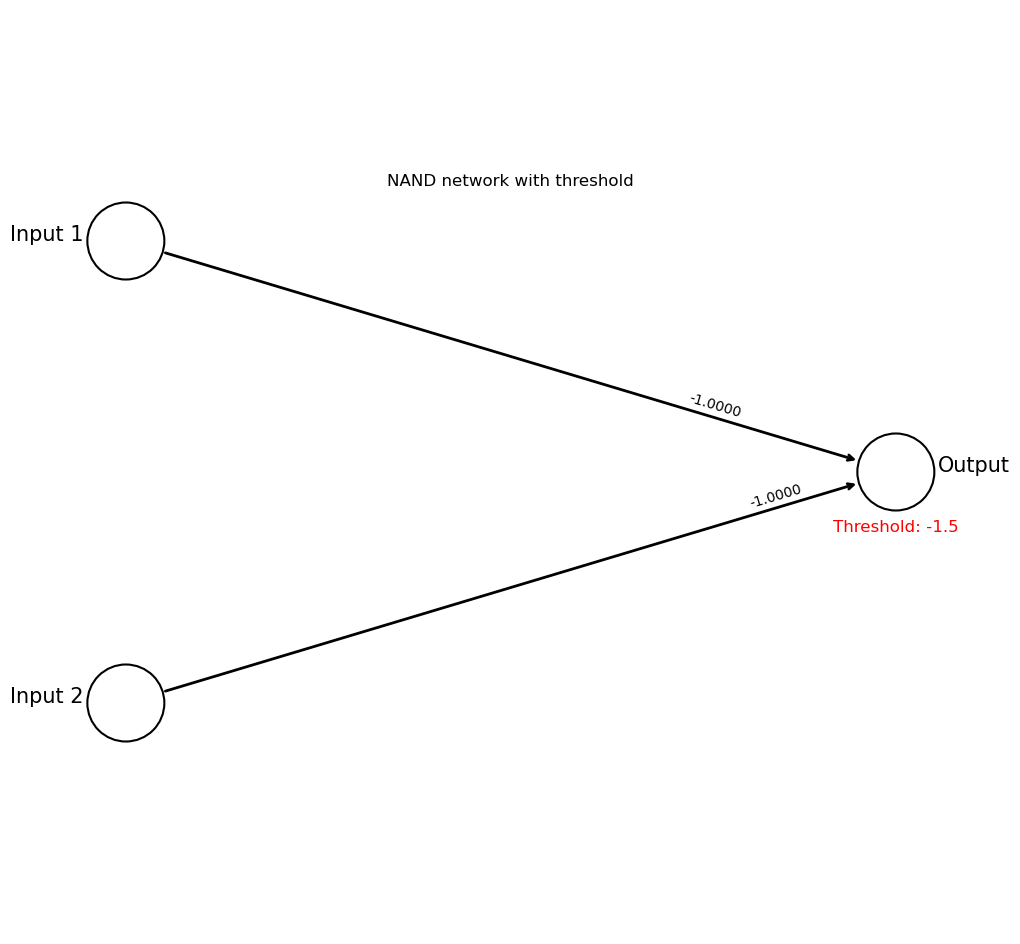

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import network_plotter as netplot

# Setup for the NAND network plot
plot_width_nand = 10.0
plot_height_nand = plot_width_nand
fig_width_nand = plot_width_nand * 1.2
fig_height_nand = fig_width_nand
figsize_nand = (fig_width_nand, fig_height_nand)

# Define the network for the NAND function
layers_nand = [
    ['Input 1', 'Input 2'],
    ['Output']
]

# Set weights for the NAND function
# Weights need to be negative to represent the NOT operation
# The threshold is set below zero to ensure activation unless both inputs are 1
input_to_output_weights_nand = np.array([-1.0, -1.0])
threshold_nand = -1.5

# Creating the figure for the NAND network
fig, ax = plt.subplots(figsize=figsize_nand)
ax.set_xlim(0, fig_width_nand)
ax.set_ylim(0, fig_height_nand)
ax.set_aspect('equal', adjustable='box')

# Calculate node positions for the NAND network
node_positions_nand = netplot.calculate_node_positions(layers_nand, plot_width_nand, fig_width_nand, fig_height_nand)

# Draw Neurons with Labels for the NAND network
num_layers_nand = len(layers_nand)
subtext_nand = ''
for i, column in enumerate(layers_nand):
    for node in column:
        pos = node_positions_nand[node]
        if i == num_layers_nand - 1:
            subtext_nand = 'Threshold: -1.5'
        netplot.draw_neuron_with_label(ax, pos, node, i, num_layers_nand, plot_width=plot_width_nand, subtext=subtext_nand)

# Draw Connections with Weights for the NAND network
for i, input_node in enumerate(layers_nand[0]):
    weight = input_to_output_weights_nand[i]
    netplot.draw_connection_with_weight(ax, node_positions_nand, input_node, 'Output', weight, show_weight=True, plot_width=plot_width_nand)

plt.title('NAND network with threshold', x=0.5, y=0.8)
plt.axis('off')
plt.show()


In [31]:
# Function to test the NAND network
def nand_network(input1, input2):
    weight1, weight2 = -1.0, -1.0  # Negative weights for the NAND operation
    threshold = -1.5  # Threshold for activation

    # Compute the weighted sum
    weighted_sum = input1 * weight1 + input2 * weight2

    # Check if the weighted sum meets or exceeds the threshold
    output = 1 if weighted_sum >= threshold else 0
    return output

# Test the network on all possible input combinations
input_combinations_nand = [(0, 0), (0, 1), (1, 0), (1, 1)]
test_results_nand = []
for inputs in input_combinations_nand:
    output = nand_network(*inputs)
    test_results_nand.append((inputs, output))
    print(f"Input: {inputs}, Output: {output}")

# alternative, less human-readable way to print results
#test_results_nand

Input: (0, 0), Output: 1
Input: (0, 1), Output: 1
Input: (1, 0), Output: 1
Input: (1, 1), Output: 0


---

## <font color='red'>Lab question 4</font>

This is interesting -- we can just change the sign on the weights and threshold from the AND network and we have implemented NAND! 

(a) Explain why these weights work. 

(b) Find other weights that will work; you may have to change the threshold. (Hint: if you solved this for AND, think about how we changed the example weights and threshold from AND for NAND...)

---

# Introducing the concept of <font color='red'>Bias</font> nodes

So far, we have been setting the threshold on our decision node. This works fine, when we can set the value by hand. This will be impractical for larger problems. It would be nice to have an alternative way to set the threshold, *and to make it tunable*. That is, if we want to eventually work with networks that learn, it will be helpful to have a way for the network to learn what thresholds to use. The standard way to do this is by using *bias nodes*.


## Understanding bias nodes in neural networks

We can think of bias nodes very simply as additional inputs that help in setting  thresholds for other nodes. Let's start with this way of thinking, and then move on to a geometric visualization. 

## Parameters for bias nodes

- **Bias Node**: A constant input (usually 1) that is connected to specific nodes (often, all non-input nodes in a network, or all nodes within a specific layer). That is, no matter what the other inputs are, the bias node always gets the same input. 
- **Threshold Setting**: The bias node allows for shifting the activation function to the left (negatively) or right (positively), which is like setting thresholds like we did above. 

## Example: AND

Remember that above we found that we can set the weights from Input 1 and Input 2 both to 1, and then set the Output threshold to 1.5 to implement AND. 

When we set the threshold, we are saying that the Output node has a *step function* for its activation function: the output is 0 if the node's total inputs are less than or equal to the threshold, or 1.0 if the node's total inputs are greater than the threshold. 

Let's see how we can re-implement this using a bias node. First, we will set a new activation function for our Output node. It will still be a step function, but now we will say the output is 0.0 unless the node's input is greater than zero. 


<div class="alert alert-block alert-info">
<b>Note:</b> <i>This may seem a little like cheating -- we are still setting a threshold. However, now we are going to use the same threshold all the time, and the bias node and its weighted connection to the output node will effectively change the threshold as needed for different tasks. Eventually, when we have networks that learn, we will be able to tune the weights from bias nodes to set task-appropriate thresholds emergently.</i></div>

The bias node will always get an input of 1.0. Now we want to figure out a weight we can use that will have the same effect as our previous approach of setting the output node's response threshold to 1.5. Let's try to do this while keeping the weights from Input 1 and Input 2 to the Output node both 1.0. 

We could try setting the bias weight to 1.5. However, if we do this, then we will always be adding 1.5 to the output node's input. If the output node is going to 'fire' when its input is > 0, this would just make it fire all the time. 

The reason 1.5 worked as a threshold was we were setting the value large enough that it could only be reached if both input nodes had values of 1. So now we want a value that will only allow the output node to fire when both inputs are 1. It will fire if its value is > 0. So we want a value to come from the weighted bias connection that will keep the output node value at or below 0 unless both inputs are 1. 

We can do this by setting the weight to *negative* 1.5 (-1.5)...


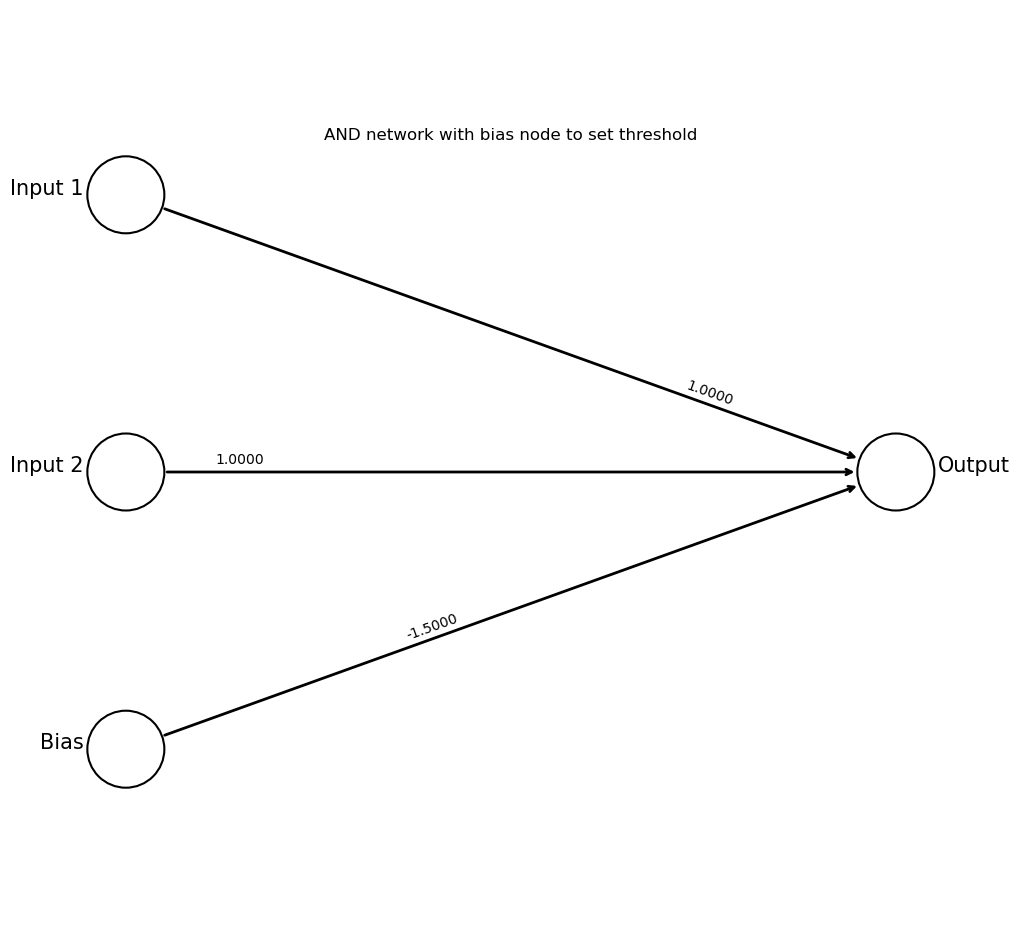

In [32]:
import network_plotter as netplot
import numpy as np
import matplotlib.pyplot as plt

# Setup for the AND network plot
plot_width = 10.0
plot_height = plot_width
fig_width = plot_width * 1.2
fig_height = fig_width
figsize = (fig_width, fig_height)

# Define the network for the AND function
layers_and = [
    ['Input 1', 'Input 2', 'Bias'],
    ['Output']
]

# Set weights for the AND function
# Both inputs need to be 1 to exceed the threshold of 1.5
input_to_output_weights_and = np.array([1.0, 1.0, -1.5])

# Creating the figure for the AND network
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlim(0, fig_width)
ax.set_ylim(0, fig_height)
ax.set_aspect('equal', adjustable='box')

# Calculate node positions for the AND network
node_positions_and = netplot.calculate_node_positions(layers_and, plot_width, fig_width, fig_height)

# Draw Neurons with Labels for the AND network
num_layers_and = len(layers_and)
subtext_and = ''
nodetext_and = ''
for i, column in enumerate(layers_and):
    for node in column:
        pos = node_positions_and[node]
        # if i == num_layers_and - 1:
        #     subtext_and = 'Threshold: 1.5'
        netplot.draw_neuron_with_label(ax, pos, node, i, num_layers_and, plot_width=plot_width, subtext=subtext_and, nodetext=nodetext_and)

# Draw Connections with Weights for the AND network
for i, input_node in enumerate(layers_and[0]):
    weight = input_to_output_weights_and[i]
    netplot.draw_connection_with_weight(ax, node_positions_and, input_node, 'Output', weight, show_weight=True, plot_width=plot_width)

plt.title('AND network with bias node to set threshold', x=0.5, y=0.85)
plt.axis('off')
plt.show()


In [33]:
def and_network_with_bias(input1, input2, bias=1):
    weight_input1, weight_input2 = 1.0, 1.0  # Weights for the input nodes
    weight_bias = -1.5  # Weight for the bias node

    # Compute the weighted sum including the bias
    weighted_sum = input1 * weight_input1 + input2 * weight_input2 + bias * weight_bias

    # The output is 1 if the weighted sum is positive, else 0
    output = 1 if weighted_sum > 0 else 0
    return output

# Test the network with bias on all possible input combinations
input_combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
for inputs in input_combinations:
    output = and_network_with_bias(*inputs)
    print(f"Input: {inputs}, Output: {output}")


Input: (0, 0), Output: 0
Input: (0, 1), Output: 0
Input: (1, 0), Output: 0
Input: (1, 1), Output: 1


## NAND with a bias node

Now let's just replot the NAND network with a bias node. 

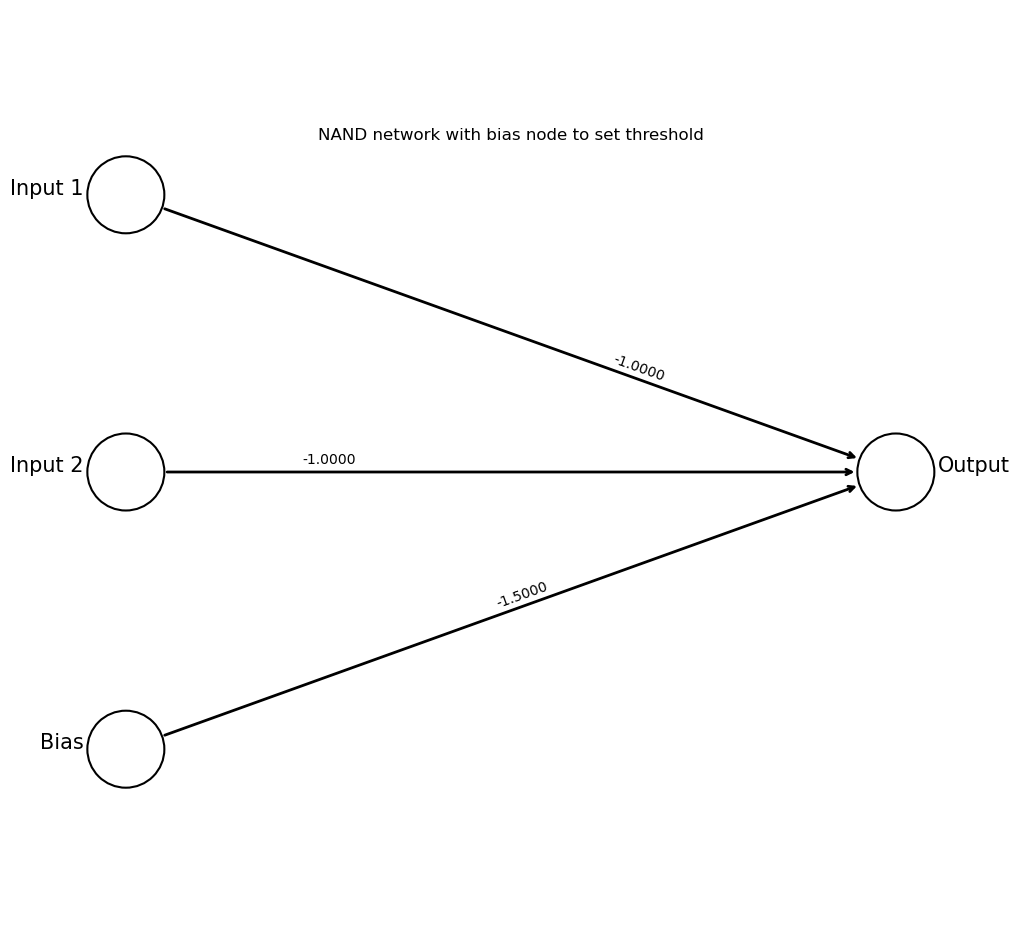

In [34]:
import network_plotter as netplot
import numpy as np
import matplotlib.pyplot as plt

# Setup for the nand network plot
plot_width = 10.0
plot_height = plot_width
fig_width = plot_width * 1.2
fig_height = fig_width
figsize = (fig_width, fig_height)

# Define the network for the nand function
layers_nand = [
    ['Input 1', 'Input 2', 'Bias'],
    ['Output']
]

# Set weights for the nand function
# Both inputs need to be 1 to exceed the threshold of 1.5
input_to_output_weights_nand = np.array([-1.0, -1.0, -1.5])

# Creating the figure for the nand network
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlim(0, fig_width)
ax.set_ylim(0, fig_height)
ax.set_aspect('equal', adjustable='box')

# Calculate node positions for the nand network
node_positions_nand = netplot.calculate_node_positions(layers_nand, plot_width, fig_width, fig_height)

# Draw Neurons with Labels for the nand network
num_layers_nand = len(layers_nand)
subtext_nand = ''
nodetext_nand = ''
for i, column in enumerate(layers_nand):
    for node in column:
        pos = node_positions_nand[node]
        # if i == num_layers_nand - 1:
        #     subtext_nand = 'Threshold: 1.5'
        netplot.draw_neuron_with_label(ax, pos, node, i, num_layers_nand, plot_width=plot_width, subtext=subtext_nand, nodetext=nodetext_nand)

# Draw Connections with Weights for the nand network
for i, input_node in enumerate(layers_nand[0]):
    weight = input_to_output_weights_nand[i]
    netplot.draw_connection_with_weight(ax, node_positions_nand, input_node, 'Output', weight, show_weight=True, plot_width=plot_width)

plt.title('NAND network with bias node to set threshold', x=0.5, y=0.85)
plt.axis('off')
plt.show()



### Using Bias to Set Threshold

- **The bias is always on**: Remember, the bias node gets a constant input (usually 1.0; we assume that value unless we are told it is different). 
- **Bias weight**: By adjusting the weight of the bias node, you can tweak the threshold at which the neuron activates. Remember, the threshold on the output node is set to 0.0 -- it 'fires' if the input is greater than 0.0. The bias node adds a value (a negative value in the case of AND) that effectively shifts the threshold. Since the input to the bias node is always 1, there is a constant value of -1.5 added to the output node's input. Therefore, the summed values from the inputs multiplied by their weights have to exceed 1.5 before the total input to the output node exceeds 0.0.

---

# Understanding the Role of Bias in a 2D Problem

In the context of machine learning and neural networks, the concept of bias is crucial for understanding how models make decisions. Let's explore this concept using the simple example of a line in 2D space.

## Equation of a Line in 2D

The general equation of a line is:

$$ y = mx + b $$

Where:
- $y$ is the output.
- $m$ is the slope of the line.
- $x$ is the input.
- $b$ is the intercept, or bias.

## Without bias

If $b$ is set to 0, we get: 

$$ y = mx + 0$$

So we can simplify this and drop the bias term ($b$):

$$ y = mx $$

### Limitations without bias
- The line will always pass through the origin (0,0).
- This limits the model's ability to fit data that is not centered around the origin.

## With bias

Including the bias term allows the line to shift up or down -- it is the intercept. 

### Overcoming limitations with bias
- The bias term ($b$) allows the line to intercept the y-axis at a point other than the origin.
- This provides flexibility to the model, enabling it to fit a wider range of data.

## Python example

The following Python code demonstrates the difference between a line with and without bias:

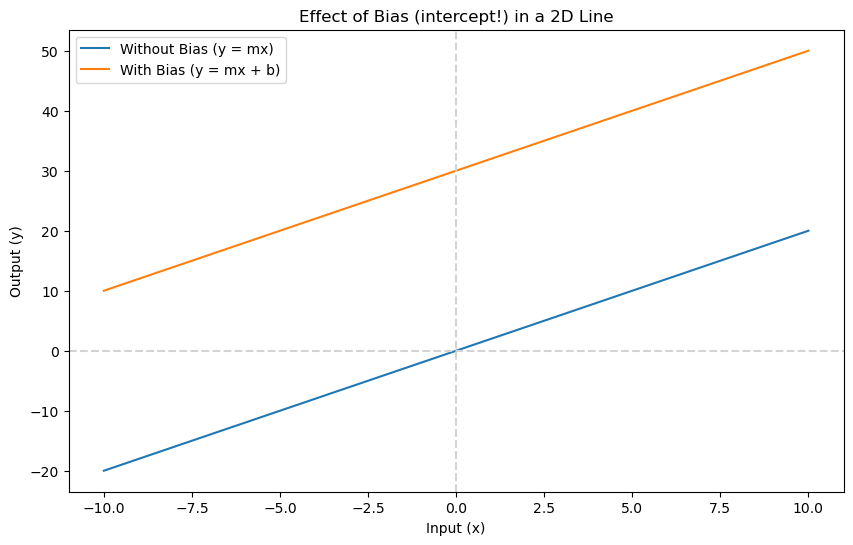

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 2  # Slope
b = 30  # Bias

# Data
x = np.linspace(-10, 10, 100)

# Line without bias
y_no_bias = m * x

# Line with bias
y_with_bias = m * x + b

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y_no_bias, label='Without Bias (y = mx)')
plt.plot(x, y_with_bias, label='With Bias (y = mx + b)')

plt.axhline(0, color='lightgrey', linestyle='--')  # Horizontal grey dashed line at y=0
plt.axvline(0, color='lightgrey', linestyle='--')  # Vertical grey dashed line at x=0
plt.title('Effect of Bias (intercept!) in a 2D Line')
plt.xlabel('Input (x)')
plt.ylabel('Output (y)')
plt.legend()
plt.show()

### What does this have to do with logic? 

Let's think about our logical functions geometrically. First, let's make a plot of the AND problem. The case where we want the network to output True (1) is the blue point. The other cases, where we want the output to be False (0), are red Xs. I've made the axes wider than seems necessary in anticipation of things I want to show you on some later plots. 

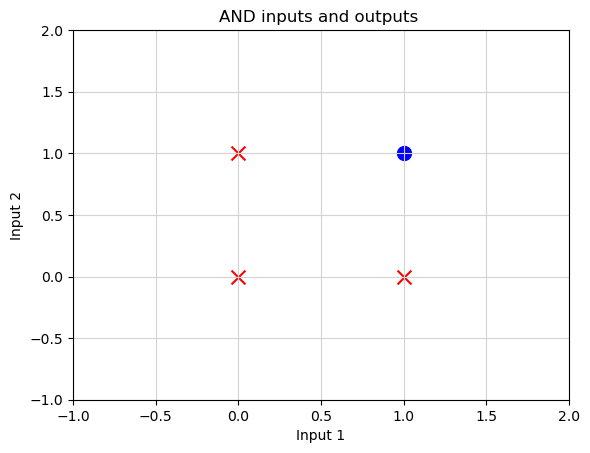

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Possible inputs and corresponding outputs for AND operation
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([0, 0, 0, 1])

# Plotting the inputs
for point, output in zip(inputs, outputs):
    if output == 1:
        plt.scatter(point[0], point[1], color='blue', marker='o', s=100)  # Output 1
    else:
        plt.scatter(point[0], point[1], color='red', marker='x', s=100)  # Output 0

# Annotations and labels
plt.title('AND inputs and outputs ')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.grid(True, color='lightgrey')
plt.show()


Okay, now let's try to draw a linear **decision boundary** for AND without bias -- a straight line that passes through 0,0 and separates the blue point from the red points. We'll see that this is not possible. Let's do this by defining a function that can take a set of input-output pairs, as well as a set of slope-bias pairs, and plot the inputs and then the lines we specify. This will allow us to call the function when we want to add new lines, or when we want to change the input-output pairs for another logical function. 

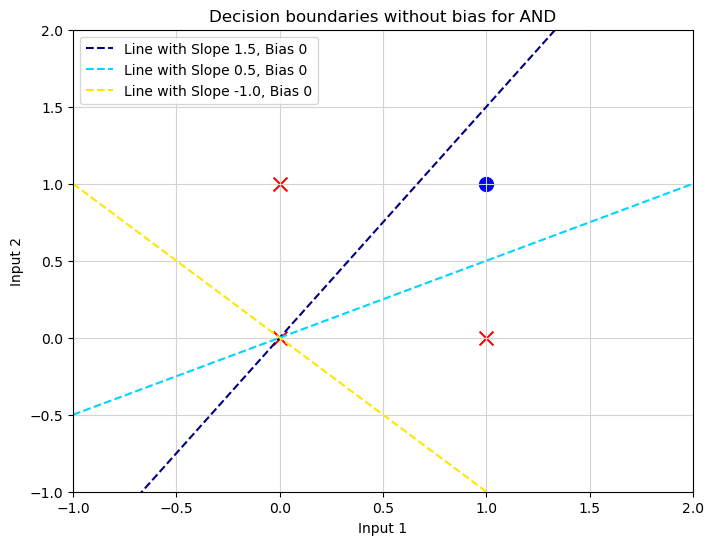

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundaries(inputs, outputs, slope_bias_pairs, ptitle='Decision boundaries'):
    """
    Plots decision boundaries for given inputs and outputs.

    Parameters:
    inputs (np.array): Array of input points.
    outputs (np.array): Array of output values corresponding to each input point.
    slope_bias_pairs (list of tuples): List of tuples where each tuple is (slope, bias).
    """
    # Plotting the inputs
    plt.figure(figsize=(8, 6))
    for point, output in zip(inputs, outputs):
        if output == 1:
            plt.scatter(point[0], point[1], color='blue', marker='o', s=100)  # Output 1
        else:
            plt.scatter(point[0], point[1], color='red', marker='x', s=100)  # Output 0

    # Plotting each decision boundary
    x = np.linspace(-1, 2, 100)
    for i, (m, b) in enumerate(slope_bias_pairs):
        y = m * x + b
        plt.plot(x, y, label=f'Line with Slope {m}, Bias {b}', linestyle='--', color=plt.cm.jet(i / len(slope_bias_pairs)))

    # Annotations and labels
    plt.title(ptitle)
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.legend()
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.grid(True, color='lightgrey')
    plt.show()

# Using the function for AND
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
outputs = np.array([0, 0, 0, 1])
slope_bias_pairs = [(1.5, 0), (0.5, 0), (-1.0, 0)]

plot_decision_boundaries(inputs, outputs, slope_bias_pairs, ptitle='Decision boundaries without bias for AND')


So we see that each line passes through 0,0 -- each line must since bias is set to 0. The way to interpret the lines is that all values on one side of the line are in one category, and the values on the other side are in the other. We want to have a line that separates the blue point from the red Xs. The line with slope of -1 (which intersects the y axis at 1 and the x axis at 1) puts 0,0 in one category, and the other 3 points in the other (what logical function does this correspond to?). The other two lines put 0,0 and one of the red Xs in one category (e.g., the line with slope 1.5 puts 0,0 and 0,1 in one category, and 1,0 and 1,1 in the other). Without bias we cannot solve this problem. However, I hope you can see that if we could draw a diagonal line parallel to the line with slope -1 but shifted up and to the right, we *could* separate the 1,1 point from the others. Let's add a line that can do this in the next plot. 

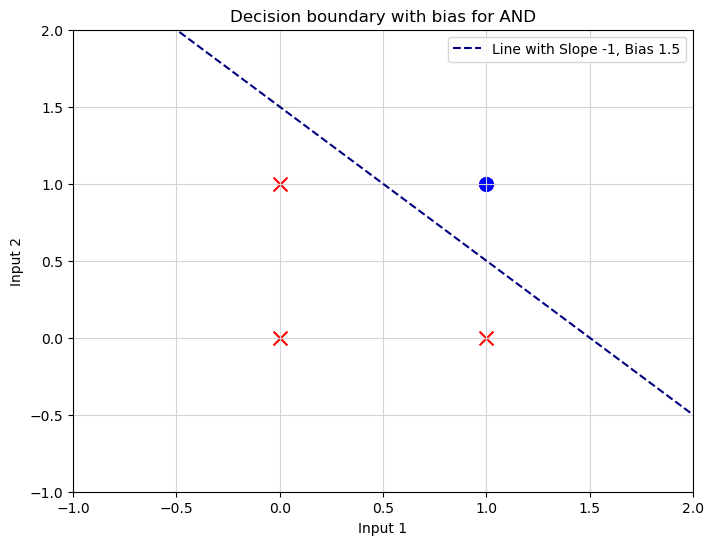

In [38]:
slope_bias_pairs = [(-1, 1.5)]

plot_decision_boundaries(inputs, outputs, slope_bias_pairs, ptitle='Decision boundary with bias for AND')


## NAND decision space

Now let's look at NAND. We just change the `outputs` appropriately. We can keep the same bias for now, but remember that we would have to change the signs of all the weights in the actual network so that it would treat 1,1 as False (0) and all the others as True. 



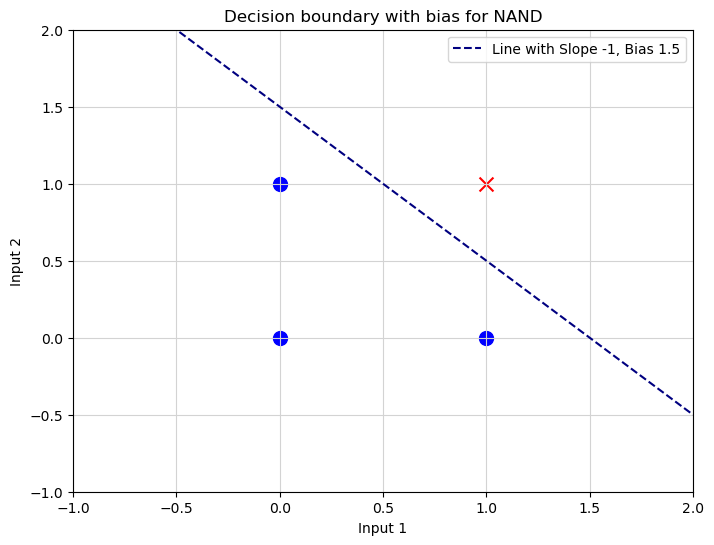

In [39]:
outputs = np.array([1, 1, 1, 0])

plot_decision_boundaries(inputs, outputs, slope_bias_pairs, ptitle='Decision boundary with bias for NAND')


## OR decision space

For OR, we are actually fine without bias, though the system would be 'brittle' in that it would not be able to tolerate any noise in the inputs. Thus, shifting the decision boundary up a bit would make the system more robust (the line with bias = 0.5). 



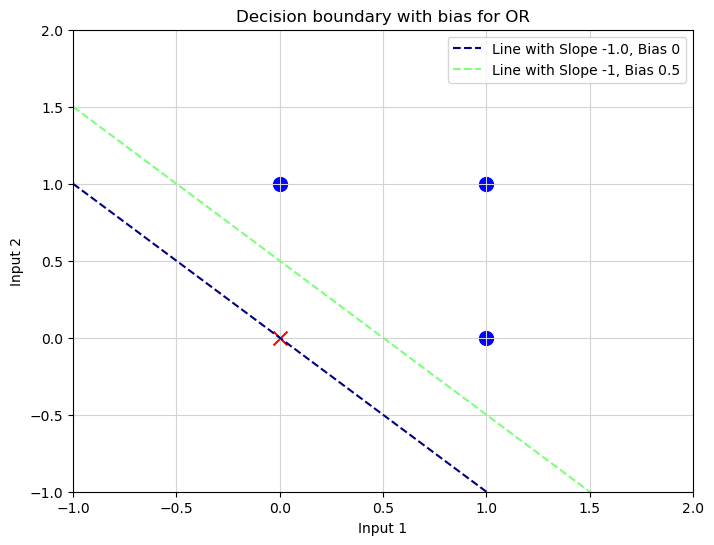

In [40]:
outputs = np.array([0, 1, 1, 1])
slope_bias_pairs = [(-1.0, 0), (-1, 0.5)]

plot_decision_boundaries(inputs, outputs, slope_bias_pairs, ptitle='Decision boundary with bias for OR')


---

## <font color='red'>Lab question 5</font>

(a) Explain what a linearly-separable mapping is. 

(b) Explain why AND, OR and NAND are linearly separable but XOR is not. 

(c) Explain what *bias* is in the current context. What are the limitations when bias is not available? To put this slightly differently, what can you do with bias that you cannot do without?  Explain it conceptually and also in terms of geometry.

---

## A tangent: more implications of bias

Right now, we are looking at networks that do simple ***classification*** -- the network tells us whether an input pair belongs to the category of True or the category of False. A more complex classification network might take in images and try to classify them as 'Dog' or 'Not dog' (or 'Dog' or 'Cat'). But often we want networks to give us *continuous* outputs -- for example, predicting the sale value of a house given the number of houses currently available in a particular area (a simple linear regression, with 1 predictor and 1 output), or the sale value of a house given number of available houses, square feet of the house, number of bedrooms, number of bathrooms, and location (e.g., lattitude and longitude) -- which would be multiple regression (multiple predictor values [inputs] and 1 predicted output value). 

Let's think about the implications of bias for the simple linear prediction case -- trying to predict a y value from an x value. 

Here's another case where **pseudo-data** will be very helpful. Let's create a function that creates some pseudo data with a particular standard deviation and range, and also a relationship between x and y based on slope and bias terms. Then let's plot the best fitting line with a bias term, and the best fitting line *without* a bias term (that has to pass through the origin,  0,0). 

We will consider how well model fits the data in two ways. First, we will calculate an index of how much total error there is -- how far in total the observed data points are from the model's prediction. Second, we will create a function for calculating $r$ (the coefficient of correlation) from a set of actual x,y values and the parameters for a line.

Let's start with the error measure we will use to assess how well our lines fit the data. 



--- 

<div class="alert alert-block alert-info">

## Mean Squared Error (MSE)

Mean Squared Error (MSE) is a common error metric used in a variety of domains. We will use it for some neural networks later in the course. But the basic idea is we have a set of predicted data points and a set of actual data points, and we want to characterize how far off the predictions are. We can't just sum the error, because some will be positive and some will be negative. We could take the **m**ean **a**bsolute values of the **e**rrors (MAE). However, MSE has advantages (it's differentiable everywhere, which will be important for neural net applications; it emphasizes larger errors since we square the values; it is less biased than MAE [for reasons outside the scope of this class]; it's directly related to variance which makes it conceptually compatible with a variety of concepts in statistics, etc.). 

### The formula to calculate MSE is:

$$
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2
$$

where:
- $ n $ is the number of data points (multiplying by $1/n$ gives us the mean of the right side of the equation, which is the summed squares of the errors)
- $ Y_i $ is the actual value for the $i^{th}$ data point.
- $ \hat{Y_i} $ is the predicted value for the $i^{th}$ data point.

The differences are squared to avoid the canceling out of positive and negative errors. The mean of these squared differences gives us the MSE.

</div>

---

Now let's do the plotting function and compare MSE with lines of best fit (that use intercept or bias terms) vs. lines that do not have an intercept (bias) and therefore must pass through the origin (0,0).  

In [48]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# This block just defines the function but doesn't do anything -- you have to call it, 
# e.g.: plot_regression_through_origin(sd=30.0, b=300.0, m=-10.0, minval=-1, maxval=50, nval=100)

# Note that I started off on a rabbit hole of thinking about R values for lines of best fit. 
# What really matters is error, which we will characterize as Mean Squared Error -- or MSE. 

import numpy as np

def calculate_r_from_line(actual_x, actual_y, slope, intercept, debug=False):
    """
    Calculates the Pearson correlation coefficient (R) between actual y values and y values predicted by a line.

    Parameters:
    actual_x (np.array): Array of x values.
    actual_y (np.array): Array of actual y values.
    slope (float): Slope of the line (model).
    intercept (float): Intercept of the line (model).

    Returns:
    float: Pearson correlation coefficient (R).
    """
    # Calculating predicted y values using the line equation
    predicted_y = slope * actual_x + intercept

    # Calculating Pearson's R
    correlation_matrix = np.corrcoef(actual_y, predicted_y)
    pearsons_r = correlation_matrix[0, 1]  # or correlation_matrix[1, 0] as the matrix is symmetric
    pearsons_r *= np.sign(slope) # 

    if debug:
        # Plotting actual vs. predicted values
        plt.figure(figsize=(8, 6))
        plt.scatter(actual_x, actual_y, color='blue', label='Actual Y Values')
        plt.scatter(actual_x, predicted_y, color='red', label='Predicted Y Values')
        plt.title('Actual vs. Predicted Y Values')
        plt.xlabel('X Values')
        plt.ylabel('Y Values')
        plt.legend()
        plt.title(f'Slope = {slope:.2f}, Intercept = {intercept:.2f}, R = {pearsons_r:.2f}')
        plt.show()

        print(actual_y)
        print(predicted_y)
    
    return pearsons_r, predicted_y

def plot_regression_through_origin(sd=1.0, b=10.0, m=10.0, minval=-5, maxval=5, nval=100,
                                  rseed=0, figwidth=8.0, figheight=6.0, ptitle="Pseudo data with lines of best fit"):
    """
    Generates a plot of pseudo data with a best fit line and a line through the origin.
    A red square is plotted at 0,0.
    
    Parameters:
    sd (float): Standard deviation of the noise.
    b (float): Intercept of the pseudo data line.
    m (float): Slope of the pseudo data line.
    minval (float): Minimum value of x in the pseudo data.
    maxval (float): Maximum value of x in the pseudo data.
    nval (int): Number of values in the pseudo data.
    rseed (int): random seed that can be set for reproducibility
    figwidth (float): figure width
    figheight (float): figure height 
    """
    # Seed for reproducibility and generating pseudo data
    np.random.seed(rseed)

    # Generating pseudo data
    x_data = np.linspace(minval, maxval, nval)
    y_data = m * x_data + b + np.random.normal(0, sd, x_data.size)

    # Calculating the best fit line with intercept
    slope, intercept, r_value, _, _ = stats.linregress(x_data, y_data)
    y_fit = slope * x_data + intercept

    # Calculating the best fitting line through the origin
    slope_origin = np.sum(x_data * y_data) / np.sum(x_data**2)
    y_fit_origin = slope_origin * x_data

    # ** not bothering with these anymore... ** 
    # Calculating R value for the line through the origin
    # Adjusted R-squared calculation
    # rss_origin = np.sum((y_data - y_fit_origin) ** 2)
    # tss_origin = np.sum(y_data**2)  # Total sum of squares from the origin
    # r_value_origin = np.sqrt(1 - rss_origin / tss_origin)  # Adjusted R-squared
    # # Adjusting the sign of R based on the slope
    # r_value_origin *= np.sign(slope_origin)
    
    
    # alternative method for calculating R, since other version is problematic
    # (was not actually problematic... but no longer using this for R; 
    #  however, still using it to get the predicted values from the line 
    #  equations so we can calculate MSE)
    # Parameters for the line (best)
    alt_r_best, pred_best = calculate_r_from_line(x_data, y_data, slope, intercept)
    alt_r_origin, pred_origin = calculate_r_from_line(x_data, y_data, slope_origin, 0)

    # MSE calculation
    mse_best = np.mean((y_data - pred_best)**2)
    mse_origin = np.mean((y_data - pred_origin)**2)
    mse_ratio = (mse_origin-mse_best) / mse_best * 100
    mse_ratio = (mse_origin/mse_best)
    
    # Plotting
    plt.figure(figsize=(figwidth, figheight))
    
    plt.scatter(x_data, y_data, color='blue', label='Pseudo Data')
    plt.plot(x_data, y_fit, color='red', label=f'Best Fit (y = {slope:.2f}x + {intercept:.2f})')
    plt.plot(x_data, y_fit_origin, color='green', label=f'Line Through Origin (y = {slope_origin:.2f}x)')

    # let's highlight the origin with a special mark and dashed lines. 
    plt.scatter([0], [0], color='red', marker='s', label='Point at Origin (0,0)')  # Red square at the origin
    plt.axhline(0, color='lightgrey', linestyle='--')  # Horizontal grey dashed line at y=0
    plt.axvline(0, color='lightgrey', linestyle='--')  # Vertical grey dashed line at x=0
    
    # Title and labels
    plt.title(ptitle)
    plt.xlabel('Input (x)')
    plt.ylabel('Output (y)')

    # Placing the legend and R value annotations
    legend = plt.legend()
    plt.gca().add_artist(legend)
    plt.text(1.05, 0.95, f'MSE ( best )={mse_best:.2f}', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)
    plt.text(1.05, 0.90, f'MSE (origin)={mse_origin:.2f}', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)
    plt.text(1.05, 0.825, f'MSE increase={mse_ratio:.2f} X ', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)

    plt.show()
    
    #return pred_best, pred_origin, y_data


Let's call it with a case where we set the bias to a small value (first plot below) and then with a larger bias (second plot). Note that we plot a red square at the origin to help us see that critical point. 

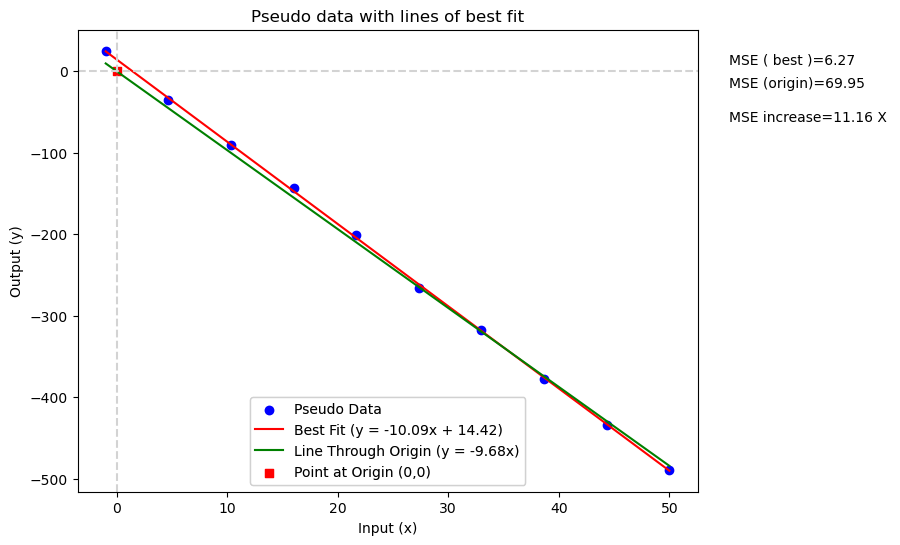

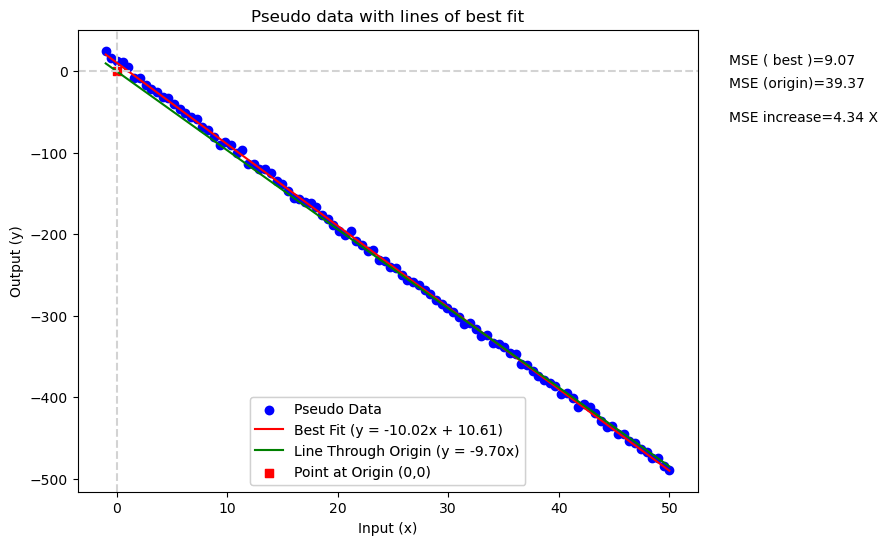

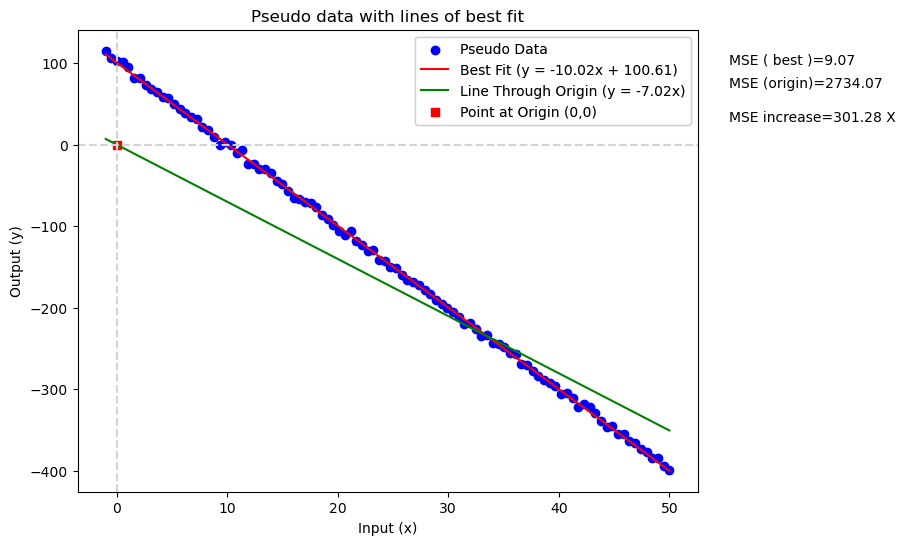

In [49]:
# Let's use it... 
plot_regression_through_origin(sd=3.0, b=10.0, m=-10.0, minval=-1, maxval=50, nval=10)
plot_regression_through_origin(sd=3.0, b=10.0, m=-10.0, minval=-1, maxval=50, nval=100)
plot_regression_through_origin(sd=3.0, b=100.0, m=-10.0, minval=-1, maxval=50, nval=100)

The function finds the conventional best-fitting line (including a bias term) and then the best possible line through the origin (0,0). This means the line that minimizes the mean distance between the line and every data point. So the green line is showing us what our prediction would be for a new x value. We can see that for the first case, the 2 lines are equivalent (because bias in the original data is low). However, in the second case, we will undershoot at low values and overshoot at high values. 

Now let's look at some other cases. First, here's one where we get a really large difference in the 2 lines. Let's also check that we get identical results when we change the sign of the slope. 

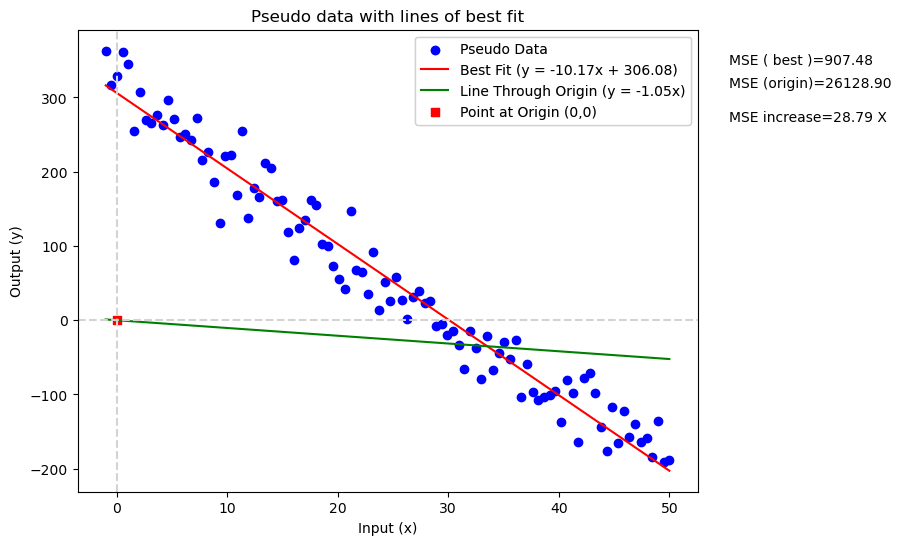

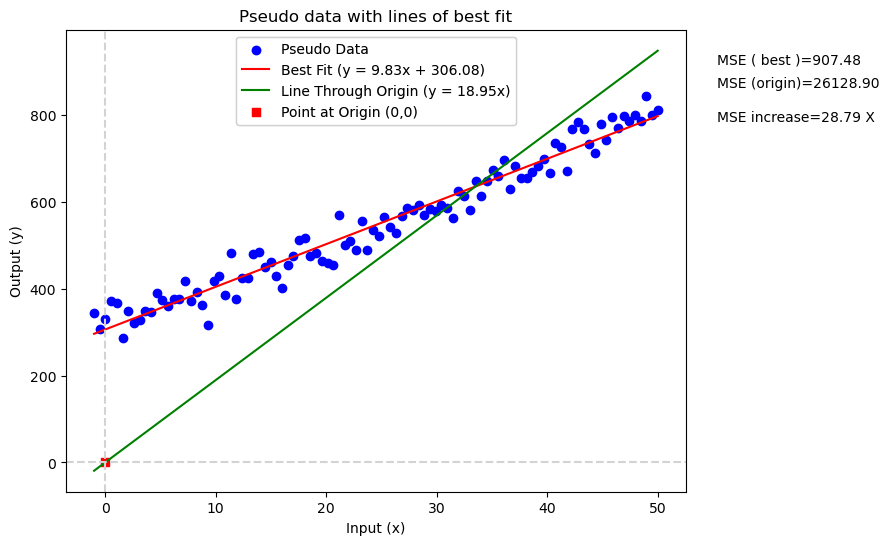

In [50]:
plot_regression_through_origin(sd=30.0, b=300.0, m=-10.0, minval=-1, maxval=50, nval=100)
plot_regression_through_origin(sd=30.0, b=300.0, m=10.0, minval=-1, maxval=50, nval=100)

Now let's look at a very important consideration here. So far, we have looked at cases where the values are mostly positive, and they are not symmetric around 0. If the values are symmetric around zero, we will get quite different relations between the lines. When this happens, the two lines have the same slope. This is because if we changed the slope of the line to rotate it clockwise (remember, it has to pass through 0,0, so we can only 'rotate' the line by changing the slope), we would decrease the error for negative values, but we would equally increase the error for positive values. 

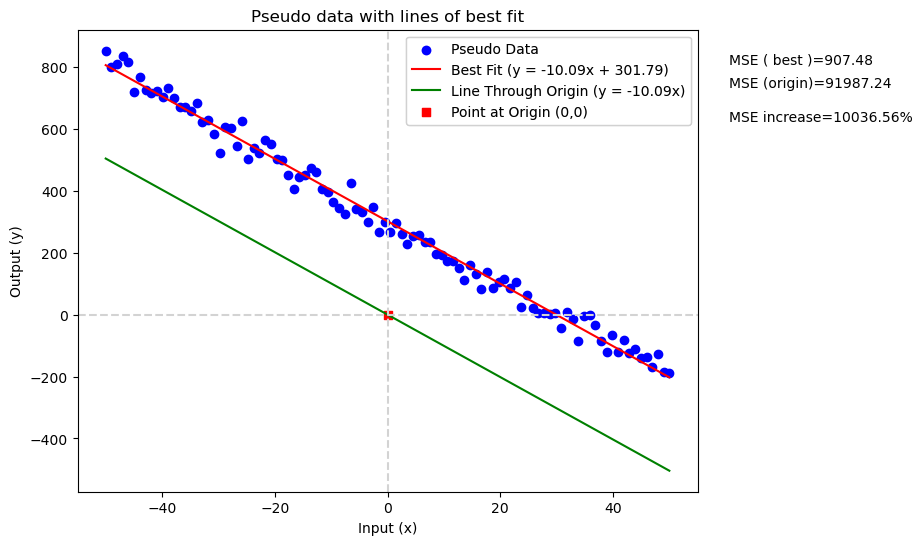

In [44]:
plot_regression_through_origin(sd=30.0, b=300.0, m=-10.0, minval=-50, maxval=50, nval=100)

---

## <font color='red'>Lab question 6</font>

(a) Explain what bias can do for fitting continously-valued 2d data (x, y pairs) (or conversely, what you cannot do without a bias term). Explain it conceptually and also in terms of geometry.

---

---

## Conclusions about bias

To sum up: bias nodes provide us with a general tool that can shift the intercept of a function computed by a network. Since a bias node has a constant input (usually 1.0) and so is *always 'on'*, we can use general methods for tuning weights to adjust the value of the weight and therefore effectively set a task-appropriate threshold. 

In the next notebook, we will start looking at ways to train networks. Then we will finally move on to the XOR function. 

